In [1]:
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException, StaleElementReferenceException, ElementClickInterceptedException
from selenium.webdriver.common.action_chains import ActionChains
import time
import random
from collections import deque # Efficiëntere queue dan een lijst

In [2]:
# --- Configuratie ---
INFINITE_CRAFT_URL = "https://neal.fun/infinite-craft/"
INITIAL_ELEMENTS = ["Water", "Fire", "Wind", "Earth"]
WAIT_TIMEOUT = 0.2  # Seconden wachttijd voor elementen
ACTION_DELAY = 0 # Kleine pauze tussen acties
COMBINATION_DELAY = 0.5 # Wachttijd na een combinatie om resultaat te zien

# --- Data Opslag ---
discovered_elements = set(INITIAL_ELEMENTS)
recipes = {} # Dict om recepten op te slaan: {(elem1, elem2): result}
elements_to_process = deque(INITIAL_ELEMENTS) # Queue van elementen om te proberen te combineren
tried_combinations = set() # Set van (sorted_tuple) van reeds geprobeerde combinaties

In [3]:
def get_element_from_sidebar(driver, element_name):
    """Zoekt een specifiek element op naam in de sidebar."""
        # XPath is vaak robuuster voor tekstinhoud, normaliseert spaties
    xpath = f"//div[contains(@class, 'item')][normalize-space()='{element_name}']"
    element = WebDriverWait(driver, WAIT_TIMEOUT).until(
        EC.presence_of_element_located((By.XPATH, xpath))
        )
    return element

def get_current_sidebar_elements(driver):
    """Haalt alle huidige elementnamen uit de sidebar."""
    elements_in_sidebar = set()
    WebDriverWait(driver, WAIT_TIMEOUT).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, "div.items"))
    )
    # Zoek alle item divs binnen de container
    # Gebruik driver.find_elements om een lijst te krijgen
    item_divs = driver.find_elements(By.CSS_SELECTOR, "div.items div.item")
    for item_div in item_divs:
        # Probeer de tekst te pakken, strip witruimte
        name = item_div.text.strip()
        if name:
            elements_in_sidebar.add(name)
    return elements_in_sidebar

def clear_canvas(driver):
    """Klikt op de 'Clear' knop om het speelveld leeg te maken."""
        # Zoek de clear knop (selector kan veranderen!)
        # Mogelijke selectors: img[src*='clear.svg'], een div met een specifieke class of id
    clear_button_xpath = "//img[contains(@class, 'clear')]" # Probeer deze XPath
    clear_button = WebDriverWait(driver, WAIT_TIMEOUT).until(
        EC.element_to_be_clickable((By.XPATH, clear_button_xpath))
    )
    print("Canvas leegmaken...")
        # Soms wordt de klik geblokkeerd, probeer met JavaScript
    driver.execute_script("arguments[0].click();", clear_button)
        # Wacht op de bevestigingsdialog
    time.sleep(ACTION_DELAY)
        # Zoek en klik op de 'Yes' knop (selector kan veranderen!)
        # Mogelijke selectors: button met text 'Yes', specifieke class
    yes_button_xpath = "//button[contains(@class, 'action-btn') and contains(text(), 'Yes')]"
    yes_button = WebDriverWait(driver, WAIT_TIMEOUT).until(
            EC.element_to_be_clickable((By.XPATH, yes_button_xpath))
        )
    driver.execute_script("arguments[0].click();", yes_button)
    print("Canvas leeggemaakt.")
    time.sleep(ACTION_DELAY) # Geef tijd om te verwerken
    return True

def combine_elements(driver, elem1_name, elem2_name):
    """Probeert twee elementen te combineren via drag-and-drop."""
    global discovered_elements # Toegang om te updaten

    print(f"Proberen te combineren: {elem1_name} + {elem2_name}")

    # 0. Zorg dat het canvas relatief leeg is voor consistentie
    if not clear_canvas(driver):
         print("Doorgaan zonder canvas te legen, resultaten kunnen onvoorspelbaar zijn.")
         # Optioneel: hier stoppen als legen essentieel is
         # return None

    # 1. Zoek de elementen in de sidebar
    elem1_sidebar = get_element_from_sidebar(driver, elem1_name)
    elem2_sidebar = get_element_from_sidebar(driver, elem2_name)

    if not elem1_sidebar or not elem2_sidebar:
        print("Een of beide elementen niet gevonden in sidebar, combinatie geannuleerd.")
        return None # Kan niet combineren

    # 2. Haal de huidige elementen op VOORDAT we combineren
    elements_before_combo = get_current_sidebar_elements(driver)
    if not elements_before_combo: # Als sidebar lezen faalt, kunnen we geen nieuw element detecteren
         print("Fout bij lezen sidebar voor combinatie.")
         return None

    # 3. Voer de drag-and-drop uit
    actions = ActionChains(driver)
        # Sleep element 1 naar het midden van het canvas (ongeveer)
        # We gebruiken 'body' als een groot doelgebied
    canvas_area = driver.find_element(By.TAG_NAME, "body") # Of specifieker: #instances
    print(f"Dragging {elem1_name} naar canvas...")
    actions.click_and_hold(elem1_sidebar).pause(ACTION_DELAY).move_to_element_with_offset(canvas_area, 100, 100).release().perform()
    time.sleep(COMBINATION_DELAY) # Wacht tot element 1 'geland' is en JS eventueel reageert



    instances_on_canvas = driver.find_elements(By.CSS_SELECTOR, "#instances .instance")
    if not instances_on_canvas:
        print(f"Kon {elem1_name} niet vinden op canvas na slepen.")
                 # clear_canvas(driver) # Probeer op te ruimen
        return None
    elem1_on_canvas = instances_on_canvas[-1] # Neem de laatste
    print(f"{elem1_name} gevonden op canvas.")


    # Sleep element 2 vanuit de sidebar OP element 1 op het canvas
    print(f"Dragging {elem2_name} op {elem1_name}...")
    actions = ActionChains(driver) # Nieuwe action chain
    actions.click_and_hold(elem2_sidebar).pause(ACTION_DELAY).move_to_element(elem1_on_canvas).release().perform()
    print("Drop voltooid.")
    time.sleep(COMBINATION_DELAY) # Wacht op het resultaat van de combinatie!

    # 4. Controleer op nieuwe elementen in de sidebar
    elements_after_combo = get_current_sidebar_elements(driver)
    newly_discovered = elements_after_combo - elements_before_combo

    if newly_discovered:
        result_element = list(newly_discovered)[0] # Neem het eerste nieuwe element
        print(f"SUCCESS: {elem1_name} + {elem2_name} = {result_element}")
        return result_element
    else:
        print(f"INFO: {elem1_name} + {elem2_name} = Geen nieuw element ontdekt.")
        return None

In [21]:
# --- Hoofdlogica ---
options = uc.ChromeOptions()
    # options.add_argument("--headless") # Headless kan problemen geven met detectie/interactie

# Specify your installed Chrome major version (135 in this case)
chrome_major_version = 135
driver = uc.Chrome(options=options, use_subprocess=True, version_main=chrome_major_version)

driver.set_window_size(1200, 800) # Pas de grootte aan voor betere zichtbaarheid
driver.set_window_position(0, 0) # Zet de positie voor zichtbaarheid
driver.implicitly_wait(2) # Korte impliciete wachttijd

driver.get(INFINITE_CRAFT_URL)

time.sleep(5) # Extra wachttijd voor alles om te settelen

# Verifieer dat de initiële elementen aanwezig zijn
initial_check = get_current_sidebar_elements(driver)
if not all(item in initial_check for item in INITIAL_ELEMENTS):
     print("WAARSCHUWING: Niet alle initiële elementen gevonden in sidebar!")
     print(f"Gevonden: {initial_check}")
     # Update discovered_elements met wat we wel zien
     discovered_elements = initial_check.copy()
     elements_to_process = deque(list(discovered_elements)) # Reset queue met wat we zien
     if not discovered_elements:
          raise Exception("Geen elementen gevonden in sidebar, kan niet starten.")

WAARSCHUWING: Niet alle initiële elementen gevonden in sidebar!
Gevonden: {'🔥 Fire', '🌍 Earth', '💧 Water', '🌬️ Wind'}


In [22]:
print(f"Starten met combineren. Elementen te verwerken: {len(elements_to_process)}")
time.sleep(2) # Extra pauze voor stabiliteit
# Hoofdlus: verwerk elementen uit de queue
processed_count = 0

elements_to_process = deque(list(discovered_elements)) # Reset queue met ontdekte elementen

while elements_to_process:
    elem1 = elements_to_process.popleft() # Pak het volgende element
    print(f"\n--- Verwerken Combinaties met: {elem1} ---")

    # Maak een kopie van de huidige bekende elementen om mee te combineren
    # Dit voorkomt problemen als de set tijdens de loop verandert
    elements_to_combine_with = list(discovered_elements)
    #random.shuffle(elements_to_combine_with) # Random volgorde kan helpen vastlopen te voorkomen
    discovered_elements_new = discovered_elements.copy() # Nieuwe set voor deze iteratie

    for elem2 in elements_to_combine_with:
       # Maak een gesorteerd tuple voor de 'tried' check (A+B is zelfde als B+A)
        combo_pair = tuple(sorted((elem1, elem2)))

            # Sla over als we deze combinatie al geprobeerd hebben of elementen gelijk zijn
        if elem1 == elem2 or combo_pair in tried_combinations:
            continue

            # Markeer als geprobeerd
        tried_combinations.add(combo_pair)

            # Probeer de combinatie
        result = combine_elements(driver, elem1, elem2)

            # Als er een nieuw resultaat is:
        if result and result not in discovered_elements_new:
            discovered_elements_new.add(result)
            elements_to_process.append(result) # Voeg toe aan queue voor latere combinaties
            recipes[combo_pair] = result
            print(f"Nieuw element toegevoegd aan queue: {result}. Queue size: {len(elements_to_process)}")
            print(f"Totaal ontdekte elementen: {len(discovered_elements_new)}")

        # Kleine pauze om niet te snel te gaan
        time.sleep(ACTION_DELAY)

    processed_count += 1
    print(f"--- Einde combinaties voor {elem1}. {processed_count} elementen verwerkt. ---")

discovered_elements = discovered_elements_new # Update de globale set met ontdekte elementen


Starten met combineren. Elementen te verwerken: 4

--- Verwerken Combinaties met: 🔥 Fire ---
--- Einde combinaties voor 🔥 Fire. 1 elementen verwerkt. ---

--- Verwerken Combinaties met: 🌍 Earth ---
--- Einde combinaties voor 🌍 Earth. 2 elementen verwerkt. ---

--- Verwerken Combinaties met: 💧 Water ---
--- Einde combinaties voor 💧 Water. 3 elementen verwerkt. ---

--- Verwerken Combinaties met: 🌬️ Wind ---
--- Einde combinaties voor 🌬️ Wind. 4 elementen verwerkt. ---


In [11]:
print("\n--- Script Klaar ---")
print(f"Totaal ontdekte elementen: {len(discovered_elements)}")
# print(f"Elementen: {sorted(list(discovered_elements))}")
print(f"\nGevonden Recepten ({len(recipes)}):")
# Sorteer recepten op resultaat voor leesbaarheid
sorted_recipes = sorted(recipes.items(), key=lambda item: item[1])
for pair, result in sorted_recipes:
    print(f"  {pair[0]} + {pair[1]} = {result}")

if driver:
    print("\nBrowser sluiten...")
    driver.quit()
    print("Browser gesloten.")


--- Script Klaar ---
Totaal ontdekte elementen: 4

Gevonden Recepten (7):
  💧 Water + 💨 Steam = ☁️ Cloud
  🌬️ Wind + 💧 Water = 🌊 Wave
  🌍 Earth + 🌬️ Wind = 🌫️ Dust
  🌍 Earth + 💧 Water = 🌱 Plant
  🌬️ Wind + 🔥 Fire = 💨 Smoke
  💧 Water + 🔥 Fire = 💨 Steam
  🌍 Earth + 💨 Steam = 💩 Mud

Browser sluiten...
Browser gesloten.


In [12]:
import csv
import os

# Define the folder name
folder_name = 'recipes'

# Create the folder if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Define the CSV file path
csv_file_path = os.path.join(folder_name, 'discovered_recipes.csv')

# Write the recipes to the CSV file
try:
    with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['Element1', 'Element2', 'Result']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for (elem1, elem2), result in recipes.items():
            writer.writerow({'Element1': elem1, 'Element2': elem2, 'Result': result})
    print(f"Recipes successfully saved to {csv_file_path}")
except Exception as e:
    print(f"Error writing recipes to CSV: {e}")

Recipes successfully saved to recipes\discovered_recipes.csv


In [19]:
# Load the CSV file into a DataFrame
df = pd.read_csv('recipes/discovered_recipes.csv')
combinations = df.to_numpy().tolist()

c:\Users\bono\anaconda3\envs\Infinitycraft\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bono\anaconda3\envs\Infinitycraft\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bono\anaconda3\envs\Infinitycraft\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bono\anaconda3\envs\Infinitycraft\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bono\anaconda3\envs\Infinitycraft\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) mi

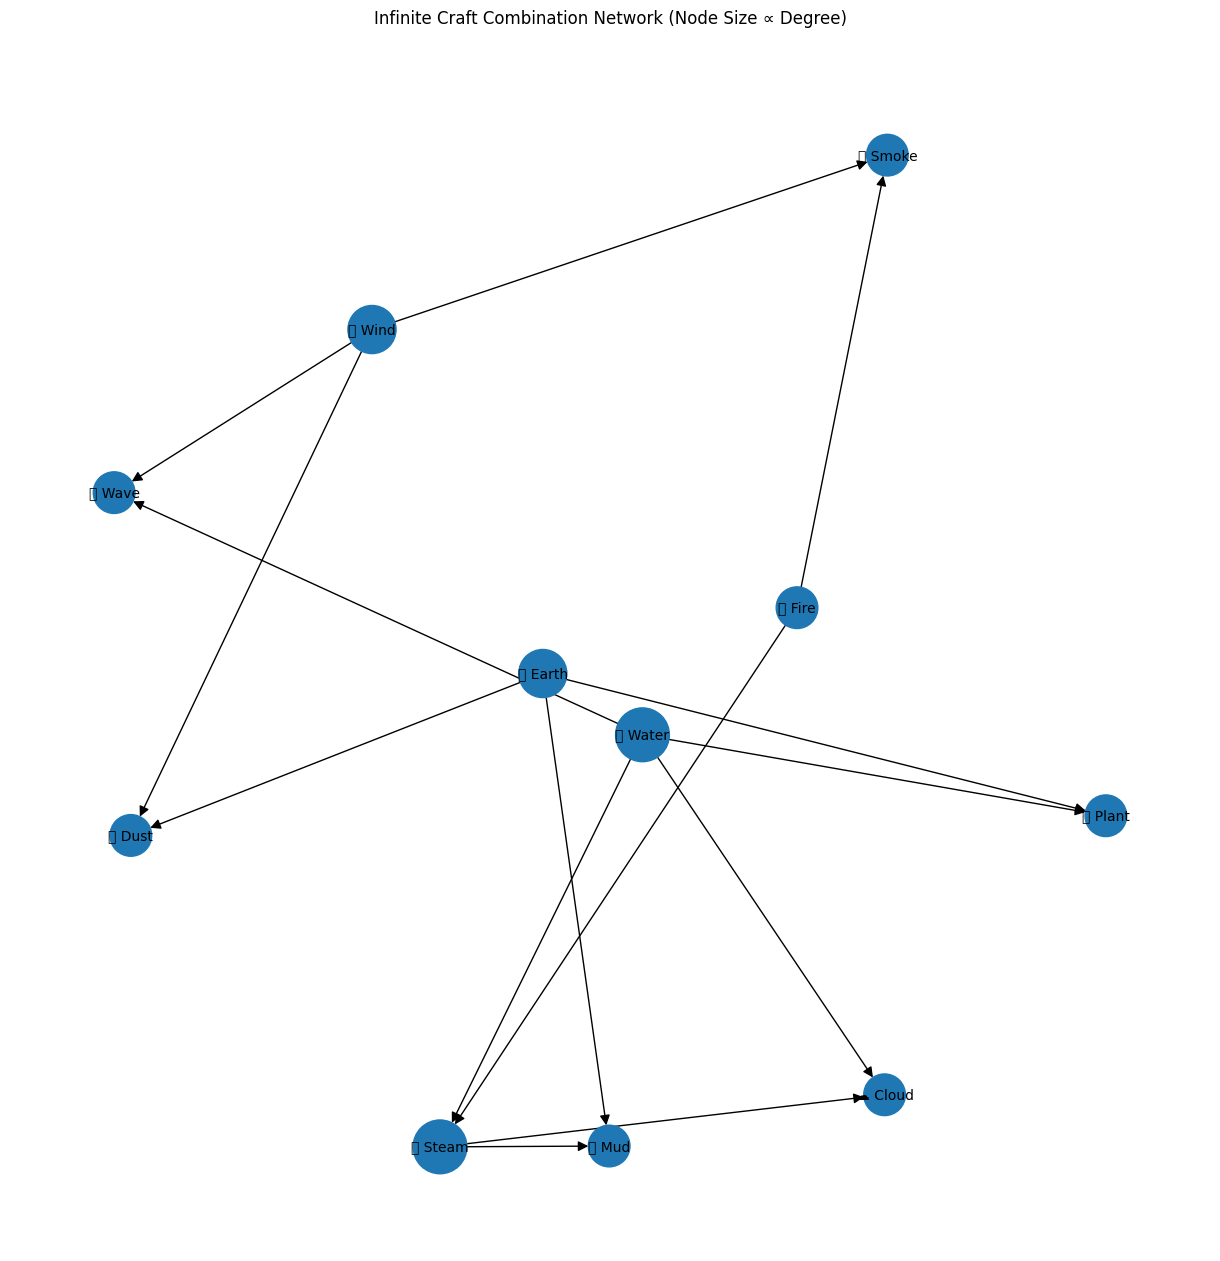

In [20]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Convert the dictionary to a DataFrame
#df = pd.DataFrame.from_dict(df, orient='index', columns=['Element1', 'Element2', 'Result']).reset_index(drop=True)

# Create directed graph
G = nx.DiGraph()
for _, row in df.iterrows():
    e1, e2, result = row['Element1'], row['Element2'], row['Result']
    G.add_node(e1)
    G.add_node(e2)
    G.add_node(result)
    G.add_edge(e1, result)
    G.add_edge(e2, result)

# Compute node sizes based on degree (number of connections)
degrees = dict(G.degree())
# Scale sizes: base size plus multiplier
node_sizes = [300 + degrees[n] * 300 for n in G.nodes()]

# Layout and draw
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=1.2, seed=42)
nx.draw(G, pos, with_labels=True, node_size=node_sizes, font_size=10, arrowsize=15)
plt.title("Infinite Craft Combination Network (Node Size ∝ Degree)", pad=20)
plt.axis('off')
plt.show()
